# Général

In [ ]:
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import hashlib
import numpy as np
import cv2 

## Analyse Exploratoire de Données (IMAGE)

In [14]:
dossier_image = '../data/raw/Flickr8k_Dataset'

### Compter le nombre total de fichiers

In [15]:
tous_fichiers = []

for f in os.listdir(dossier_image):
    chemin = os.path.join(dossier_image, f)
    if os.path.isfile(chemin):
        tous_fichiers.append(f)

print("Nombre total de fichiers dans le dossier :", len(tous_fichiers))

Nombre total de fichiers dans le dossier : 8091


### Compter le nombre de fichiers par extension

In [16]:
extensions = []

for f in tous_fichiers:
    _, ext = os.path.splitext(f)
    ext = ext.lower()
    if ext == '':
        extensions.append('Sans extension')
    else:
        extensions.append(ext)

compteur_extensions = Counter(extensions)

print("Nombre de fichiers par extension :")
for ext, count in compteur_extensions.items():
    print(ext, ":", count)

Nombre de fichiers par extension :
.jpg : 8091


### Vérifier si les images sont corrompues

In [17]:
images_corrompues = []

for f in tous_fichiers:
    if f.lower().endswith('.jpg'):
        chemin_image = os.path.join(dossier_image, f)
        try:
            with Image.open(chemin_image) as img:
                img.verify()
        except Exception as e:
            images_corrompues.append((f, str(e)))

if len(images_corrompues) == 0:
    print("Toutes les images JPG sont valides et non corrompues.")
else:
    print(len(images_corrompues), "images JPG corrompues détectées :")
    for nom, erreur in images_corrompues:
        print("-", nom, ":", erreur)

Toutes les images JPG sont valides et non corrompues.


### Vérifier la résolution des images

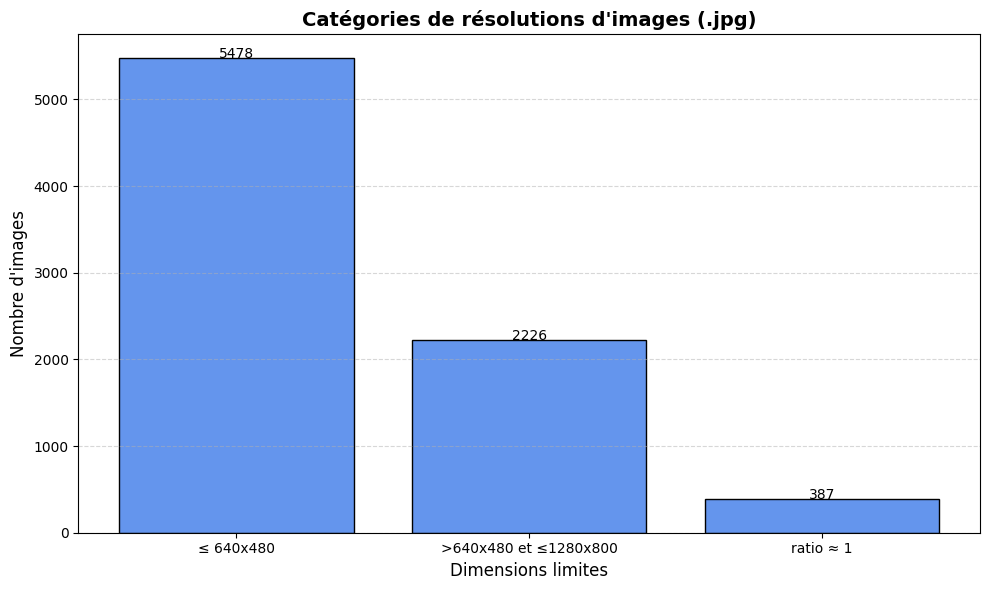

In [18]:
tous_fichiers = os.listdir(dossier_image)

categories = {
    "Petit": 0,
    "Moyen (HD)": 0,
    "Grand (Full HD)": 0,
    "Très grand (2K/4K+)": 0,
    "Carré": 0,
    "Autre": 0
}

dimensions_repr = {
    "Petit": "≤ 640x480",
    "Moyen (HD)": ">640x480 et ≤1280x800",
    "Grand (Full HD)": "≤1920x1080",
    "Très grand (2K/4K+)": "≥ 2560x",
    "Carré": "ratio ≈ 1",
    "Autre": "Autres"
}

def classifier_resolution(w, h):
    ratio = w / h
    if abs(ratio - 1) <= 0.1:
        return "Carré"
    elif w <= 640 and h <= 480:
        return "Petit"
    elif w <= 1280 and h <= 800:
        return "Moyen (HD)"
    elif w <= 1920 and h <= 1080:
        return "Grand (Full HD)"
    elif w >= 2560:
        return "Très grand (2K/4K+)"
    else:
        return "Autre"

#Parcours des images
for f in tous_fichiers:
    if f.lower().endswith('.jpg'):
        chemin_image = os.path.join(dossier_image, f)
        try:
            with Image.open(chemin_image) as img:
                w, h = img.size
                cat = classifier_resolution(w, h)
                categories[cat] += 1
        except:
            pass

#Filtrer les catégories avec au moins 1 image
labels_filtrés = [label for label, val in categories.items() if val > 0]
valeurs_filtrées = [val for val in categories.values() if val > 0]

#Dimensions à afficher sur l'axe X à la place des noms
x_labels = [dimensions_repr[label] for label in labels_filtrés]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(valeurs_filtrées)), valeurs_filtrées, color='cornflowerblue', edgecolor='black')

plt.title("Catégories de résolutions d'images (.jpg)", fontsize=14, weight='bold')
plt.xlabel("Dimensions limites", fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

#Valeurs numériques au-dessus des barres
for i, val in enumerate(valeurs_filtrées):
    plt.text(i, val + 0.5, str(val), ha='center', fontsize=10)

#Remplacer les ticks X par les dimensions
plt.xticks(range(len(x_labels)), x_labels)

plt.tight_layout()
plt.show()


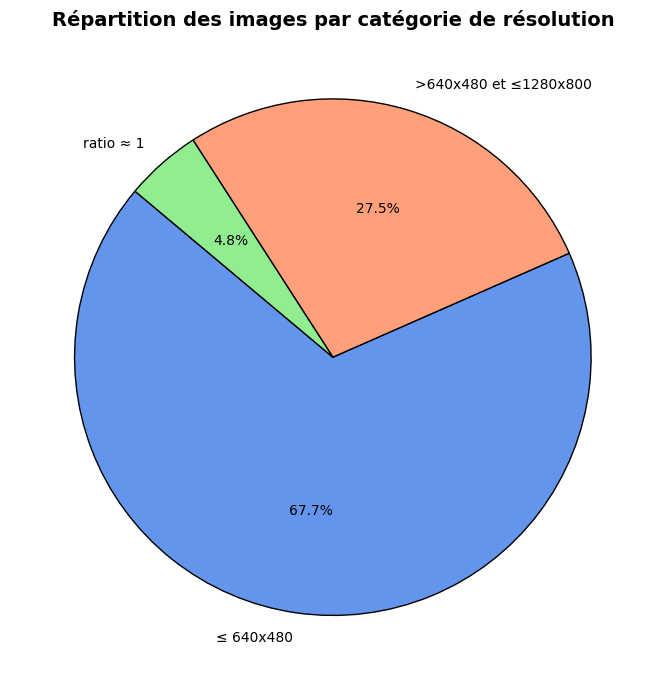

In [19]:
colors = ['#6495ED', '#FFA07A', '#90EE90', '#FFD700', '#90EE90', '#D3D3D3'] 

plt.figure(figsize=(7,7))
plt.pie(valeurs_filtrées,
        labels=[dimensions_repr[l] for l in labels_filtrés], 
        colors=colors[:len(valeurs_filtrées)],
        autopct='%1.1f%%',
        startangle=140,
        wedgeprops={'edgecolor': 'black'})

plt.title("Répartition des images par catégorie de résolution", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

#### 📊 Interprétation succincte et concrète des résolutions d'images

- **Majorité d’images de petite résolution (≤ 640x480)**  
  Elles représentent environ **65%** de ton dataset.  
  ➔ Tes images proviennent majoritairement de sources **basse résolution** : photos mobiles anciennes, captures rapides ou images web.

- **Une part significative d’images de résolution moyenne (640x480 à 1280x800)**  
  Avec environ **27%**, ce groupe contient des images avec **plus de détails**.  
  ➔ Utile pour des **annotations plus précises** et un meilleur entraînement des modèles.

- **Images carrées (ratio ≈ 1) : une minorité (~5%)**  
  Ce format est **souvent lié aux réseaux sociaux** (ex. Instagram).  
  ➔ À considérer à part ou à **recadrer** pour une meilleure homogénéité.

- **Autres catégories (Grand, Très grand, Autre) : très minoritaires**  
  Cela indique que ta base est **essentiellement constituée d’images de faible à moyenne résolution**.

---

#### 🤖 Ce que ça implique pour le modèle

- **Majorité d’images basse résolution (≤ 640x480)**  
  ➔ Le modèle sera principalement entraîné sur des images avec **peu de détails**.  
  ➔ Il pourrait **bien détecter les objets** quand ils sont **gros et visibles**, mais **peiner sur les petits objets** ou les détails fins.

- **Images de résolution moyenne (640x480 - 1280x800)**  
  ➔ Ces images apportent **plus de richesse visuelle**, utiles pour mieux **généraliser** sur des cas variés.  
  ➔ Elles **équilibrent** le dataset et peuvent **renforcer la robustesse** du modèle.

- **Images carrées ou hors normes**  
  ➔ Étant peu nombreuses, le modèle risque de **moins bien gérer** ces cas à l'entraînement.  
  ➔ Un **pré-traitement adapté** (recadrage, redimensionnement **sans distorsion**) est recommandé pour garantir l'homogénéité.

---


#### 🎯 Stratégies pour chaque catégorie de résolution afin de limiter les biais

#### 🟦 1. Images de petite résolution (≤ 640x480)
- 📉 Risque : Perte de détails → mauvaise reconnaissance de petits objets.
- ✅ Actions recommandées :
  - **Suréchantillonner** ou **augmenter les images** (zoom, crop, upscale modéré).
  - **Éviter le sur-redimensionnement** qui introduit du flou.
  - Si possible, compléter avec des images similaires mais en meilleure qualité.

#### 🟨 2. Images de résolution moyenne (640x480 - 1280x800)
- 👍 Bon équilibre entre taille et qualité.
- ✅ Actions recommandées :
  - Conserver telles quelles ou **redimensionner légèrement** vers une taille standard (ex. : 800x600).
  - Servir de **base de référence** pour les autres catégories.

#### 🟥 3. Images de haute résolution (≥ 1280x800 jusqu’à 2K/4K)
- 📉 Risque : Si trop peu nombreuses → peu d’impact à l'entraînement.
- ✅ Actions recommandées :
  - **Redimensionner à une taille standard** (ex. 800x600 ou 640x480).
  - Ne pas les supprimer si elles sont rares — elles peuvent enrichir la diversité.
  - Attention à ne pas **perdre d’objets petits** en réduisant trop.

#### 🟩 4. Images carrées (ratio ≈ 1)
- 📉 Risque : Format peu représenté → possible biais du modèle.
- ✅ Actions recommandées :
  - **Recadrer ou paddder** pour les ramener à un ratio standard (ex. 4:3 ou 16:9).
  - Si elles sont utiles (ex : visuels de réseaux sociaux), envisager de les regrouper ou d’en ajouter d’autres.

#### ⚪ 5. Autres formats (non standards)
- 📉 Risque : Distorsion lors du redimensionnement sans précaution.
- ✅ Actions recommandées :
  - Analyser au cas par cas : recadrage intelligent ou padding.
  - Uniformiser le ratio globalement pour faciliter l’entraînement.

### ✅ En résumé :
- Viser une **résolution cohérente** à l’entrée du modèle (ex : 640x480 ou 800x600).
- Appliquer des **prétraitements adaptés à chaque cas** : recadrage, redimensionnement, padding.
- **Équilibrer** le dataset par augmentation ou en réduisant les extrêmes pour éviter qu’un type de résolution domine.

---

### Vérifier la couleur

In [20]:
modes = {}

for f in tous_fichiers:
    if f.lower().endswith('.jpg'):
        chemin_image = os.path.join(dossier_image, f)
        try:
            with Image.open(chemin_image) as img:
                mode = img.mode
                if mode in modes:
                    modes[mode] += 1
                else:
                    modes[mode] = 1
        except:
            pass

print("Modes couleur trouvés et leur nombre :")
for mode, count in modes.items():
    print(f"{mode} : {count}")


Modes couleur trouvés et leur nombre :
RGB : 8091


### Vérifier les doublons

Images JPG uniques : 8090
Doublons détectés : 1


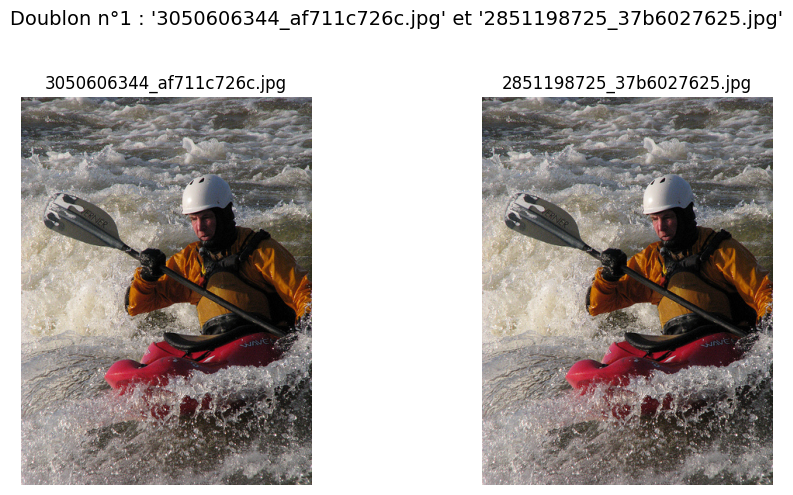

In [21]:
def calculer_md5(chemin_fichier):
    hasher = hashlib.md5()
    with open(chemin_fichier, 'rb') as f:
        while True:
            bloc = f.read(65536)
            if not bloc:
                break
            hasher.update(bloc)
    return hasher.hexdigest()

hashes = {}
doublons = []

for f in os.listdir(dossier_image):
    if f.lower().endswith('.jpg'):
        chemin_image = os.path.join(dossier_image, f)
        h = calculer_md5(chemin_image)
        if h in hashes:
            doublons.append((f, hashes[h]))
        else:
            hashes[h] = f

print(f"Images JPG uniques : {len(hashes)}")
print(f"Doublons détectés : {len(doublons)}")

if doublons:
    for i, (f1, f2) in enumerate(doublons, start=1):
        chemin1 = os.path.join(dossier_image, f1)
        chemin2 = os.path.join(dossier_image, f2)

        img1 = Image.open(chemin1)
        img2 = Image.open(chemin2)

        plt.figure(figsize=(10,5))
        plt.suptitle(f"Doublon n°{i} : '{f1}' et '{f2}'", fontsize=14)

        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title(f1)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title(f2)
        plt.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])  
        plt.show()
else:
    print("Aucun doublon détecté.")


### Vérifier la qualité des images

Images trop sombres : 23
Images trop claires : 81
Images floues : 18
Images correctes : 7969


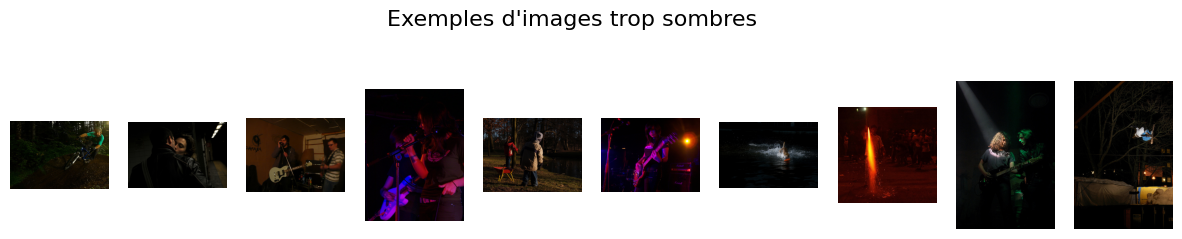

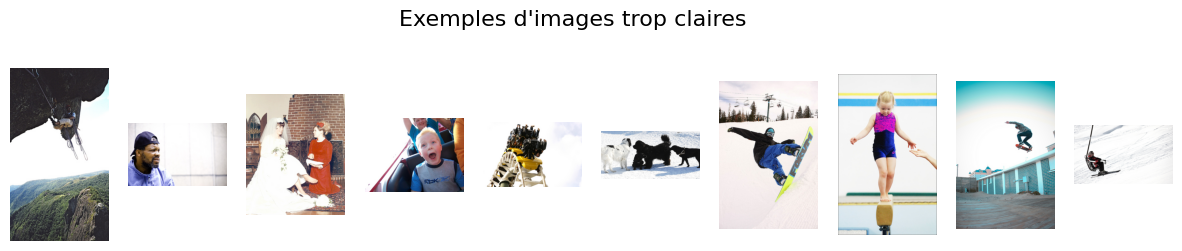

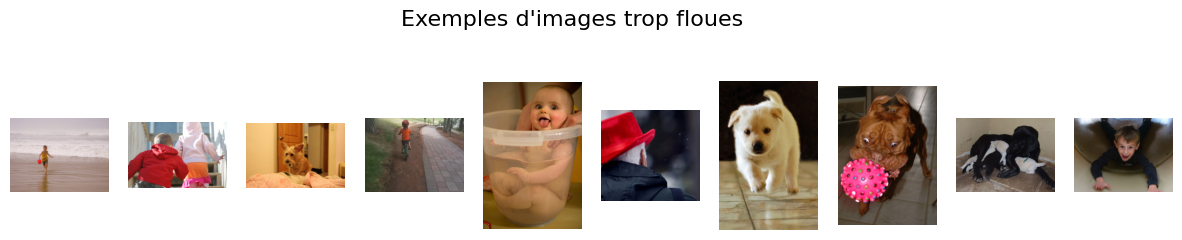

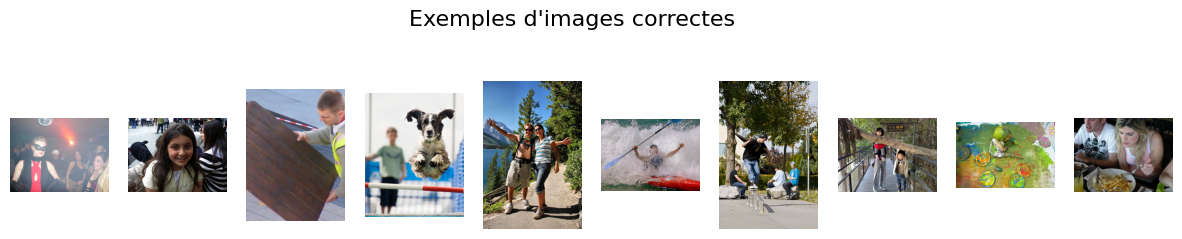

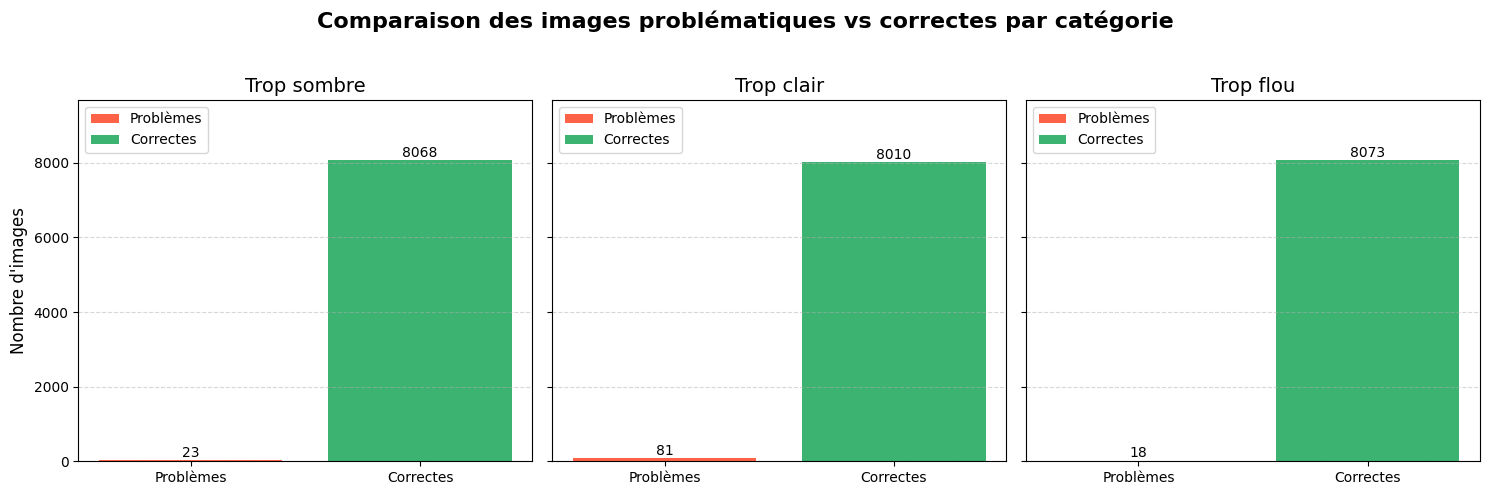

In [22]:
def luminosite_moyenne(image_path):
    img = Image.open(image_path).convert('L')
    np_img = np.array(img)
    return np_img.mean()

def luminosite_locale(image_path, seuil_pixel=80, pourcentage_min=5):
    img = Image.open(image_path).convert('L')
    np_img = np.array(img)
    nb_pixels_clairs = np.sum(np_img > seuil_pixel)
    total_pixels = np_img.size
    pourcentage_clair = 100 * nb_pixels_clairs / total_pixels
    return pourcentage_clair >= pourcentage_min

def trop_clair_local(image_path, seuil_pixel=240, pourcentage_max=30):
    img = Image.open(image_path).convert('L')
    np_img = np.array(img)
    nb_pixels_clairs = np.sum(np_img > seuil_pixel)
    total_pixels = np_img.size
    pourcentage_clair = 100 * nb_pixels_clairs / total_pixels
    return pourcentage_clair > pourcentage_max

def variance_laplacian(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return cv2.Laplacian(img, cv2.CV_64F).var()

#Seuils (ajuster selon dataset)
seuil_sombre = 50
seuil_lum_local = 5  # %
seuil_trop_clair = 30  # %
seuil_flou = 100

#Stockage résultats
images_trop_sombres = []
images_trop_claires = []
images_floues = []
images_correctes = []

exemples_trop_sombres = []
exemples_trop_claires = []
exemples_floues = []
exemples_correctes = []

max_exemples = 10

for f in os.listdir(dossier_image):
    if f.lower().endswith('.jpg'):
        chemin = os.path.join(dossier_image, f)
        try:
            lum_moy = luminosite_moyenne(chemin)
            lum_loc = luminosite_locale(chemin, pourcentage_min=seuil_lum_local)
            clair = trop_clair_local(chemin, pourcentage_max=seuil_trop_clair)
            var_lap = variance_laplacian(chemin)

            #Trop sombre ?
            if lum_moy < seuil_sombre and not lum_loc:
                images_trop_sombres.append(f)
                if len(exemples_trop_sombres) < max_exemples:
                    exemples_trop_sombres.append(chemin)
                continue

            #Trop clair ?
            if clair:
                images_trop_claires.append(f)
                if len(exemples_trop_claires) < max_exemples:
                    exemples_trop_claires.append(chemin)
                continue

            #Trop flou ?
            if var_lap is not None and var_lap < seuil_flou:
                images_floues.append(f)
                if len(exemples_floues) < max_exemples:
                    exemples_floues.append(chemin)
                continue

            #Sinon correct
            images_correctes.append(f)
            if len(exemples_correctes) < max_exemples:
                exemples_correctes.append(chemin)

        except Exception as e:
            print(f"Erreur sur {f} : {e}")

print(f"Images trop sombres : {len(images_trop_sombres)}")
print(f"Images trop claires : {len(images_trop_claires)}")
print(f"Images floues : {len(images_floues)}")
print(f"Images correctes : {len(images_correctes)}")

#Fonction pour afficher exemples (à réutiliser)
def afficher_exemples(liste_chemins, titre):
    import matplotlib.pyplot as plt
    if not liste_chemins:
        print(f"Aucun exemple pour {titre}")
        return
    n = len(liste_chemins)
    plt.figure(figsize=(15, 3))
    plt.suptitle(titre, fontsize=16)
    for i, chemin_img in enumerate(liste_chemins):
        img = Image.open(chemin_img)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

#Affichage
afficher_exemples(exemples_trop_sombres, "Exemples d'images trop sombres")
afficher_exemples(exemples_trop_claires, "Exemples d'images trop claires")
afficher_exemples(exemples_floues, "Exemples d'images trop floues")
afficher_exemples(exemples_correctes, "Exemples d'images correctes")

#Données pour les graphes
categories = ["Trop sombre", "Trop clair", "Trop flou"]
problemes = [len(images_trop_sombres), len(images_trop_claires), len(images_floues)]
total_images = len(images_trop_sombres) + len(images_trop_claires) + len(images_floues) + len(images_correctes)

#Correctes = images sans ce problème (exclusif)
corrects = [total_images - p for p in problemes]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, ax in enumerate(axs):
    bars_problemes = ax.bar(['Problèmes'], [problemes[i]], color='tomato', label='Problèmes')
    bars_corrects = ax.bar(['Correctes'], [corrects[i]], color='mediumseagreen', label='Correctes')
    ax.set_title(categories[i], fontsize=14)
    ax.set_ylim(0, max(problemes + corrects) * 1.2)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    if i == 0:
        ax.set_ylabel('Nombre d\'images', fontsize=12)
    ax.legend()

    # Ajout des valeurs au-dessus des barres
    for bar in bars_problemes + bars_corrects:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 5, str(height), ha='center', va='bottom', fontsize=10)

plt.suptitle("Comparaison des images problématiques vs correctes par catégorie", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### ✅ Interprétation

- **Images trop sombres** (23 cas) :
  - Faible luminosité globale sans zone lumineuse significative.
  - Risque de perte d’informations visuelles → le modèle pourrait mal apprendre.

- **Images trop claires** (81 cas) :
  - Forte proportion de pixels surexposés (valeurs > 240).
  - Peut nuire à la détection d’objets sur fond très clair ou blanc.

- **Images floues** (18 cas) :
  - Variance du Laplacien faible → contours peu marqués.
  - Ces images peuvent réduire la capacité du modèle à distinguer les bords et formes.
---

#### 📈 Implications pour l'entraînement

- Un **modèle entraîné sur des images sur/sous-exposées ou floues** peut :
  - Apprendre des représentations visuelles erronées.
  - Être moins robuste à la variation de qualité des images en test réel.
  - Nécessiter un traitement ou équilibrage préalable pour éviter les biais.

---

#### 🛠️ Stratégies recommandées

- 🔧 **Prétraitement des images** :
  - Éclaircir légèrement les images trop sombres avec histogramme égalisé ou gamma correction.
  - Réduire la surexposition (ex. clip intensité max, ajustement contraste).
  - Améliorer légèrement la netteté avec des filtres adaptés (e.g. unsharp masking).

- 🗃️ **Tri ou exclusion** :
  - Supprimer ou isoler les images trop extrêmes pour préserver la qualité moyenne.
  - Utiliser ces images dans des scénarios d’augmentation contrôlée si nécessaire.

- 📉 **Équilibrage** :
  - Réduire la surreprésentation des images trop claires si elles biaisent les résultats.
  - Éventuellement compenser les catégories minoritaires par duplication ou génération d’images (data augmentation).
---

🎯 **Images à exclure ou à traiter en inférence**

| Type d'image       | Pourquoi les exclure ?                                                       | Recommandation                                 |
|--------------------|-----------------------------------------------------------------------------|------------------------------------------------|
| 🕶️ Trop sombres      | Informations visuelles peu exploitables, objets non visibles → risque de mauvaise prédiction. | ✅ À exclure si non récupérables par prétraitement. |
| ☀️ Trop claires      | Surexposition → objets fondus dans le blanc, perte de contours.             | ⚠️ À filtrer ou corriger si c’est récupérable.       |
| 🌫️ Floues            | Bords non définis → le modèle pourrait ne pas détecter les objets ou mal les classer. | ✅ À exclure si très floues, sinon renforcer les bons exemples. |
---

🧠 **Raisonnement :**

L’objectif en inférence est d’éviter les erreurs graves ou bruitées dues à des images non exploitables.

Mieux vaut filtrer les cas problématiques connus à l’avance (images de mauvaise qualité) que d’introduire de l’incertitude ou du bruit dans les prédictions.

Si tu veux traiter toutes les images en inférence, tu peux :

- les prétraiter automatiquement (éclaircir, corriger, filtrer),
- ou les flagger comme "basse qualité" pour que le modèle ou le pipeline décisionnel les traite différemment.
---